# **Experiment: MNIST**

This notebook reproduces results of the numerical experiments in

> D. Castelli Lacunza and C. A. Sing Long, "*Adaptive multipliers for frequency extrapolation*." January 28, 2025. [arXiv:2501.17019](https://doi.org/10.48550/arXiv.2501.17019).

You can use the following code to cite our work.

```bibtex
@misc{lacunza_adaptive_2025,
	title     = {Adaptive multipliers for extrapolation in frequency},
	doi       = {10.48550/arXiv.2501.17019},
	number    = {{arXiv}:2501.17019},
	publisher = {{arXiv}},
	author    = {Castelli Lacunza, Diego and Sing Long, Carlos A.},
	date      = {2025-01-28}}
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

if "../.." not in sys.path:
    sys.path.insert(0, "../..")

SAVE_FIGURES = False

def savefig(fname, data_digit):
  if SAVE_FIGURES:
    plt.savefig(f'FIG/E02_{fname:s}_D{data_digit:d}.png', bbox_inches='tight', dpi=300)
    plt.savefig(f'FIG/E02_{fname:s}_D{data_digit:d}.eps', bbox_inches='tight')

## Contents
1. [Dataset](#dataset)
2. [Function collection](#function-collection)
3. [Multiplier](#multiplier)
4. [Optimal multiplier](#optimal-multiplier)
5. [Extrapolation in frequency](#extrapolation-in-frequency)

## Dataset

Define first the functions in the collection in the Fourier domain.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X_data, X_labels = mnist["data"].to_numpy(), mnist["target"]
X_labels = X_labels.astype(int)

Restrict the data to images about a single digit. 

In [3]:
data_digit = 8
X_data = X_data[X_labels == data_digit]

Set resolution parameters.

In [4]:
# image pixels (hardcoded)
N = (28, 28)
# pixel size
dx = [ 1/N[0], 1/N[1] ]

print('Resolution')
print(f'Space        {dx[0]:.3E} x {dx[1]:.3E}')
print(f'Resolution   {N[0]:d} x {N[1]:d}')

Resolution
Space        3.571E-02 x 3.571E-02
Resolution   28 x 28


Generate the coefficient matrix ``A`` by extracting ``num_data`` random samples.  

Matrix size             500 x 784
Maximum singular value  1.699E+02
Minimum singular value  1.127E-15
Rank                    473


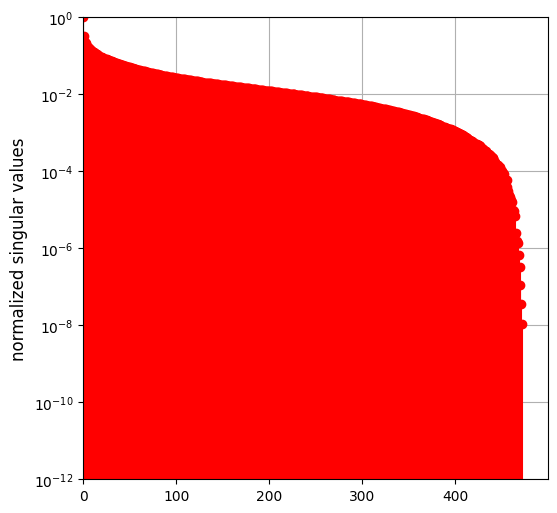

In [5]:
# this puts the origin on the lower-left corner
X_data = X_data.reshape((X_data.shape[0], N[0], N[1]))
X_data = X_data[:, ::-1, :]
# number of images
num_data = 500
# selection of images
# random
#data_index = np.random.randint(0, num_data, num_data)
# deterministic / for reproducibility
data_index = [ I for I in range(num_data) ] 
# selection of images
A = X_data[data_index].reshape((num_data, N[0] * N[1]))
A = A / 255
# conditioning
sv_A = np.linalg.svdvals(A)
# singular values to evaluate best/worst cases
rank_A = np.sum(np.where(sv_A/sv_A[0] > 1E-9, 1, 0))

print(f'Matrix size             {A.shape[0]:d} x {A.shape[1]:d}')
print(f'Maximum singular value  {sv_A[0]:.3E}')
print(f'Minimum singular value  {sv_A[-1]:.3E}')
print(f'Rank                    {rank_A:d}')

# plot
plt.figure(figsize=(6, 6))
plt.stem(range(sv_A.size), sv_A/sv_A[0], markerfmt='ro', linefmt='r-', basefmt='r-')
plt.xlim([ -0.5, sv_A.size - 0.5 ])
plt.ylim([ 1E-12, 1E0 ])
plt.ylabel('normalized singular values', fontsize=12)
plt.yscale('log')
plt.grid('both')
plt.show()

Plot the first ``36`` images.

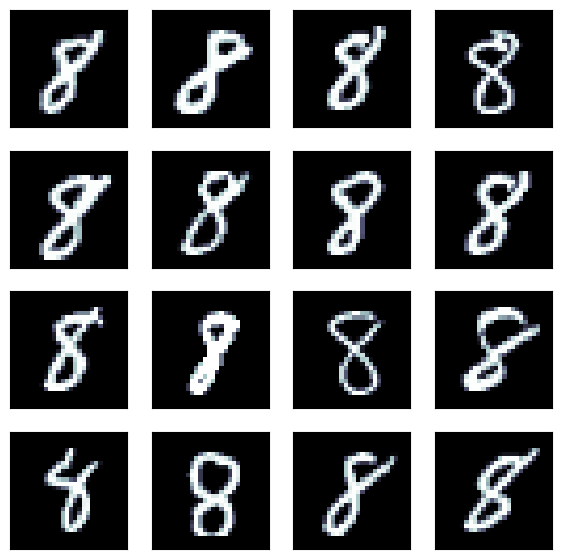

In [6]:
plt.figure(figsize=(7, 7))
for I in range(16):
  plt.subplot(4, 4, I + 1)
  plt.imshow(A[I].reshape(N), vmin=0.0, vmax=1.0, origin='lower', cmap='bone')
  plt.xticks([])
  plt.yticks([])
savefig('DATA', data_digit)
plt.show()

## Function collection

The collection $\mathcal{U}$ comprises the images extrapolated to $\mathbb{R}^2$ by using the indicator function of pixels of size $\Delta x_1 \times \Delta x_2$. The support of each function is contained on $[0, 1]\times [0, 1]$. The collection $\mathcal{F}$ is defined using using the function ``shifted_exponential_collection`` in ``routines.collections``. 

In [7]:
from adaptiveExtrapolationInFrequency.routines.collections import shifted_exponential_collection

The Fourier transform of the indicator function of each pixel is a scaled $\operatorname{sinc}$ function.

In [8]:
def basis_fourier(w):
  return dx[0] * dx[1] * np.sinc(dx[0] * w.T[0]) * np.sinc(dx[1] * w.T[1])

# location of pixels / this is the center of the pixel
xo = np.meshgrid((0.5 + np.linspace(0, N[0] - 1, N[0])) / N[0], (0.5 + np.linspace(0, N[1] - 1, N[1])) / N[1])
xo = np.vstack([ xo[0].ravel(), xo[1].ravel() ]).T

Define the vector-valued function directly.

In [9]:
# size of collection
num_f = xo.shape[0]
# vector-valued function
f = shifted_exponential_collection(2, xo, basis_fourier, A)

## Multiplier

Define the multiplier associated to the collection. We use an annulus with $r_{\min} = 0.5$ and $r_{\max} = 2.0$. The goal is to evaluate frequency extrapolation to a disk or radius $r_{\operatorname{hi}} = 8.0$ from a disk of radius $r_{\operatorname{lo}} = 2.0$. However, in this case we subdivide the annulus in different sectors, and a multiplier is selected for each one of them. In this case the extrapolation is *anisotropic*.

In [10]:
from adaptiveExtrapolationInFrequency.objects.domain import Sector2D, Circle2D
from adaptiveExtrapolationInFrequency.objects.multiplier import SMultiplier

In [11]:
# minimum frequency
rmin = 0.5
# maximum frequency
rmax = 2.0
# superresolution factor
alpha = 4.0
# sectors
num_sectors = 2
theta = np.linspace(0, np.pi, num_sectors + 1)
theta = theta - 0.5 * (theta[1] - theta[0])

# low-resolution domain
DC_lo = Circle2D(r = rmax)
# high-resolution domain
DC_hi = Circle2D(r = alpha * rmax)
# domains for frequency extrapolation
DAs = [ Sector2D(rmin = rmin, rmax = rmax, tmin = theta[I], tmax = theta[I+1]) for I in range(num_sectors) ]
# multipliers
mSs = [ SMultiplier(ndim = 2, alpha = alpha, domain = DA, f_vec = f) for DA in DAs ]

Plot the sectors.

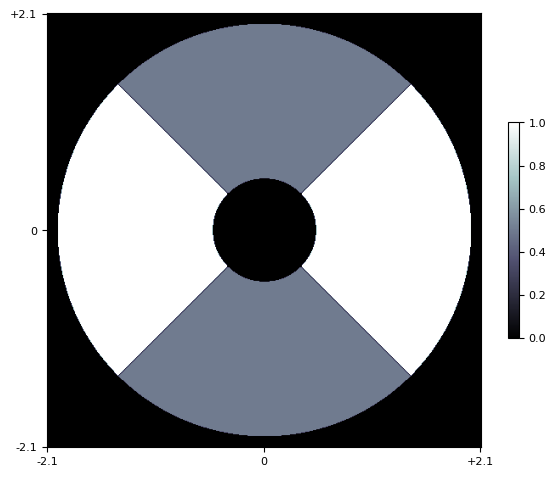

In [12]:
# frequency range
num_w = 512
w_max = DC_lo.r + 0.1
wmsh = np.meshgrid(np.linspace(-w_max, +w_max, num_w), np.linspace(-w_max, +w_max, num_w))
w = np.vstack([ wmsh[0].ravel(), wmsh[1].ravel() ]).T

# sectors
X_sec = np.zeros((num_w, num_w))
for I, mS in enumerate(mSs):
  X_sec = X_sec + (num_sectors - I) * mS.domain.eval_window(w).reshape((num_w, num_w)) / num_sectors
# plot
plt.figure(figsize=(7, 7))
plt.imshow(X_sec, vmin=0.0, vmax=1.0, cmap='bone', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(7, 7))
plt.imshow(X_sec, vmin=0.0, vmax=1.0, cmap='bone', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
savefig('SECTORS', data_digit)
plt.close()

## Optimal multiplier

To compute the optimal multiplier we import the ``FixedPointIteration`` from ``objects.solver`` and ``ProjSchattenLp`` from ``objects.projector``. 

In [13]:
from adaptiveExtrapolationInFrequency.objects.solver import FixedPointIteration
from adaptiveExtrapolationInFrequency.objects.projector import ProjSchattenLp

In [14]:
# instance of FPI
FPE = FixedPointIteration()
# set verbose = True
FPE.verbose = True

# projector
P = ProjSchattenLp(n = num_f, p = np.inf)

In [15]:
# parameters
FPE.tG = 0.15
FPE.tS = 0.75

FPE.maxitns = 200
FPE.print_every = 10
FPE.num_nodes_max = 50000
FPE.num_nodes_factor = 1.05

In [16]:
Sopts = [ FPE.solve(mS, P) for mS in mSs ]

 itn      | obj(m)     | |x|       | |dx|      | nq     
        1 | +4.446E-03 | 2.236E+01 | 2.232E+01 |   1050
       10 | +9.151E-03 | 1.661E-02 | 1.206E-03 |   1628
       20 | +9.141E-03 | 1.602E-02 | 4.883E-04 |   2653
       30 | +9.627E-03 | 1.649E-02 | 3.889E-04 |   4321
       40 | +9.477E-03 | 1.645E-02 | 2.531E-04 |   7039
       50 | +9.471E-03 | 1.647E-02 | 2.262E-04 |  11467
       60 | +9.461E-03 | 1.644E-02 | 1.551E-04 |  18679
       70 | +9.433E-03 | 1.642E-02 | 1.198E-04 |  30426
       80 | +9.480E-03 | 1.644E-02 | 1.079E-04 |  49561
 itn      | obj(m)     | |x|       | |dx|      | nq     
       90 | +9.503E-03 | 1.647E-02 | 9.174E-05 |  50000
      100 | +9.495E-03 | 1.649E-02 | 9.650E-05 |  50000
      110 | +9.434E-03 | 1.640E-02 | 1.075E-04 |  50000
      120 | +9.440E-03 | 1.645E-02 | 1.006E-04 |  50000
      130 | +9.480E-03 | 1.644E-02 | 1.351E-04 |  50000
      140 | +9.453E-03 | 1.647E-02 | 8.227E-05 |  50000
      150 | +9.395E-03 | 1.636E-02 | 8.766E-05

Plot the optimal multiplier.

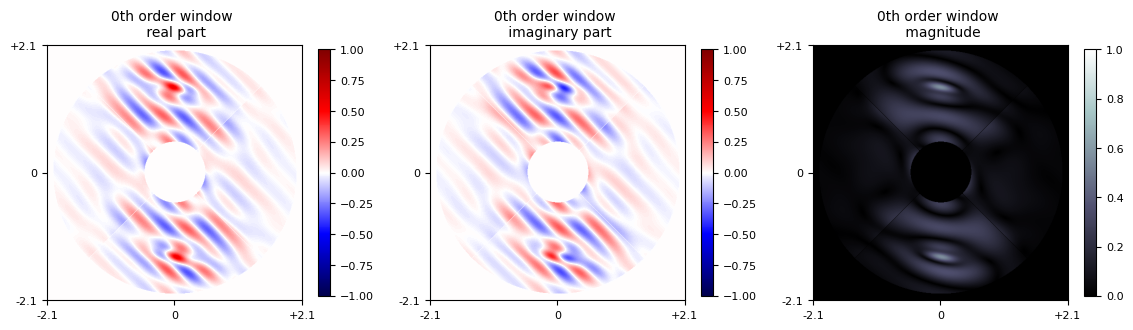

In [17]:
mw_w = np.zeros((num_w ** 2,), dtype=complex)
for I, (mS, Sopt) in enumerate(zip(mSs, Sopts)):
  mw_w = mw_w + mS.eval_windowed(Sopt, w)

# plot
plt.figure(figsize=(14, 8))
plt.subplot(1, 3, 1)
plt.imshow(mw_w.reshape((num_w, num_w)).real, vmin=-1.0, vmax=1.0, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title('0th order window \n real part', fontsize=10)
plt.subplot(1, 3, 2)
plt.imshow(mw_w.reshape((num_w, num_w)).imag, vmin=-1.0, vmax=1.0, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title('0th order window \n imaginary part', fontsize=10)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(mw_w).reshape((num_w, num_w)), vmin=0.0, vmax=1.0, cmap='bone', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=8)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=8)
plt.title('0th order window \n magnitude', fontsize=10)
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(12, 7))
plt.subplot(1, 3, 1)
plt.imshow(mw_w.reshape((num_w, num_w)).real, vmin=-1.0, vmax=1.0, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
plt.title('real part', fontsize=14)
plt.subplot(1, 3, 2)
plt.imshow(mw_w.reshape((num_w, num_w)).imag, vmin=-1.0, vmax=1.0, cmap='seismic', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
plt.title('imaginary part', fontsize=14)
plt.subplot(1, 3, 3)
plt.imshow(np.abs(mw_w).reshape((num_w, num_w)), vmin=0.0, vmax=1.0, cmap='bone', origin='lower')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
plt.title('magnitude', fontsize=14)
savefig('MOPT', data_digit)
plt.close()

Compute and plot the optimal multipliers in the spatial domain.

In [18]:
from adaptiveExtrapolationInFrequency.routines.integrals import inverse_fourier_transform_2d_squares

In [19]:
# spatial range
num_x = 256
x_max = 5
xmsh = np.meshgrid(np.linspace(-x_max + 0.5, +x_max + 0.5, num_x), np.linspace(-x_max, +x_max, num_x))
x = np.vstack([ xmsh[0].ravel(), xmsh[1].ravel() ], dtype=float).T
# coefficients for interpolation
M = 72 * np.ones((2,), dtype=int)
# inverse fourier transform
u_xs = [ inverse_fourier_transform_2d_squares(lambda w : mS.eval_windowed(Sopt, w), x, 0.5 * mS.domain.width, M).reshape((num_x, num_x)) for mS in mSs ]
u_xs_max = [ np.abs(u_x).max() for u_x in u_xs ]

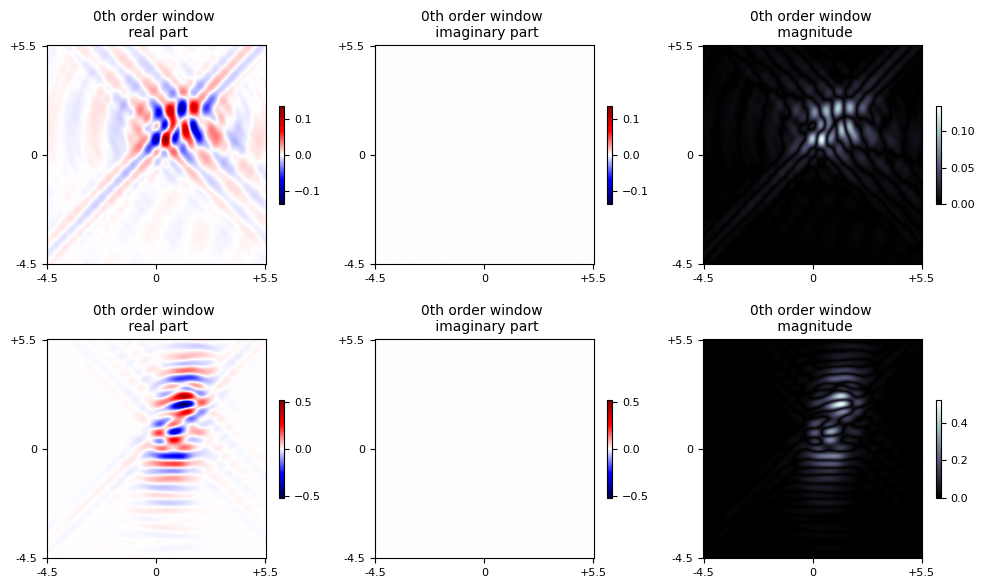

In [20]:
# plot
plt.figure(figsize=(12, num_sectors * 3.5))
for I, (u_x, u_x_max) in enumerate(zip(u_xs, u_xs_max)):
  plt.subplot(num_sectors, 3, 1 + I * 3)
  plt.imshow(u_x.real, vmin=-u_x_max, vmax=+u_x_max, cmap='seismic', origin='lower')
  plt.xticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
  plt.yticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.title('0th order window \n real part', fontsize=10)
  plt.subplot(num_sectors, 3, 2 + I * 3)
  plt.imshow(u_x.imag, vmin=-u_x_max, vmax=+u_x_max, cmap='seismic', origin='lower')
  plt.xticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
  plt.yticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.title('0th order window \n imaginary part', fontsize=10)
  plt.subplot(num_sectors, 3, 3 + I * 3)
  plt.imshow(np.abs(u_x), vmin=0.0, vmax=u_x_max, cmap='bone', origin='lower')
  plt.xticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
  plt.yticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0', f'{+x_max + 0.5:+.1f}' ], fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.title('0th order window \n magnitude', fontsize=10)
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
for I, (u_x, u_x_max) in enumerate(zip(u_xs, u_xs_max)):
  # individual plots
  plt.ioff()
  plt.figure(figsize=(7, 7))
  plt.imshow(u_x.real, vmin=-u_x_max, vmax=+u_x_max, cmap='seismic', origin='lower')
  plt.xticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0', f'{+x_max + 0.5:+.1f}' ], fontsize=12)
  plt.yticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0', f'{+x_max + 0.5:+.1f}' ], fontsize=12)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=10)
  plt.title('real part', fontsize=14)
  savefig(f'MOPT_X_SECTOR{I}', data_digit)
  plt.close()
# joint plot
for I, (u_x, u_x_max) in enumerate(zip(u_xs, u_xs_max)):
  plt.ioff()
  plt.figure(figsize=(7, 7))
  plt.imshow(u_x.real, vmin=-u_x_max, vmax=+u_x_max, cmap='seismic', origin='lower')
  plt.xticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0', f'{+x_max + 0.5:+.1f}' ], fontsize=12)
  plt.yticks([ 0, (num_x - 1) / 2, num_x-1 ], labels=[ f'{-x_max + 0.5:+.1f}', '0', f'{+x_max + 0.5:+.1f}' ], fontsize=12)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=10)
  plt.title(f'sector {I+1}', fontsize=14)
  savefig(f'MOPT_X_SECTOR{I}', data_digit)
  plt.close()

## Extrapolation in frequency

Perform extrapolation in frequency.

In [21]:
# number of images
num_imgs = 5
# discretization parameter
M = ( 64, 64 )
# selected images
# random
#img_index = np.random.randint(0, num_data, num_imgs)
# deterministic / for reproducibility
img_index = [ I for I in range(num_imgs) ]

Show extrapolation in the frequency domain.

In [22]:
# frequency range
num_w = 256
w_max = DC_hi.r + 0.1 
wmsh = np.meshgrid(np.linspace(-w_max, +w_max, num_w), np.linspace(-w_max, +w_max, num_w))
w = np.vstack([ wmsh[0].ravel(), wmsh[1].ravel() ]).T

In [23]:
# low- and high-frequency
X_los = np.array([ (DC_lo.eval_window(w) * f(w)[I]).reshape((num_w, num_w)) for I in img_index ])
X_his = np.array([ (DC_hi.eval_window(w) * f(w)[I]).reshape((num_w, num_w)) for I in img_index ])

In [24]:
X_exts = np.zeros((num_imgs, num_w, num_w), dtype=complex)
# extrapolation in frequency
for I, index in enumerate(img_index):
  X_exts[I] = X_los[I]
  for mS, Sopt in zip(mSs, Sopts):
      X_exts[I] = X_exts[I] + (DC_hi.eval_window(w) * (1 - DC_lo.eval_window(w)) * mS.eval_windowed(Sopt, w/alpha) * f(w/alpha)[index]).reshape((num_w, num_w))

Plot the results.

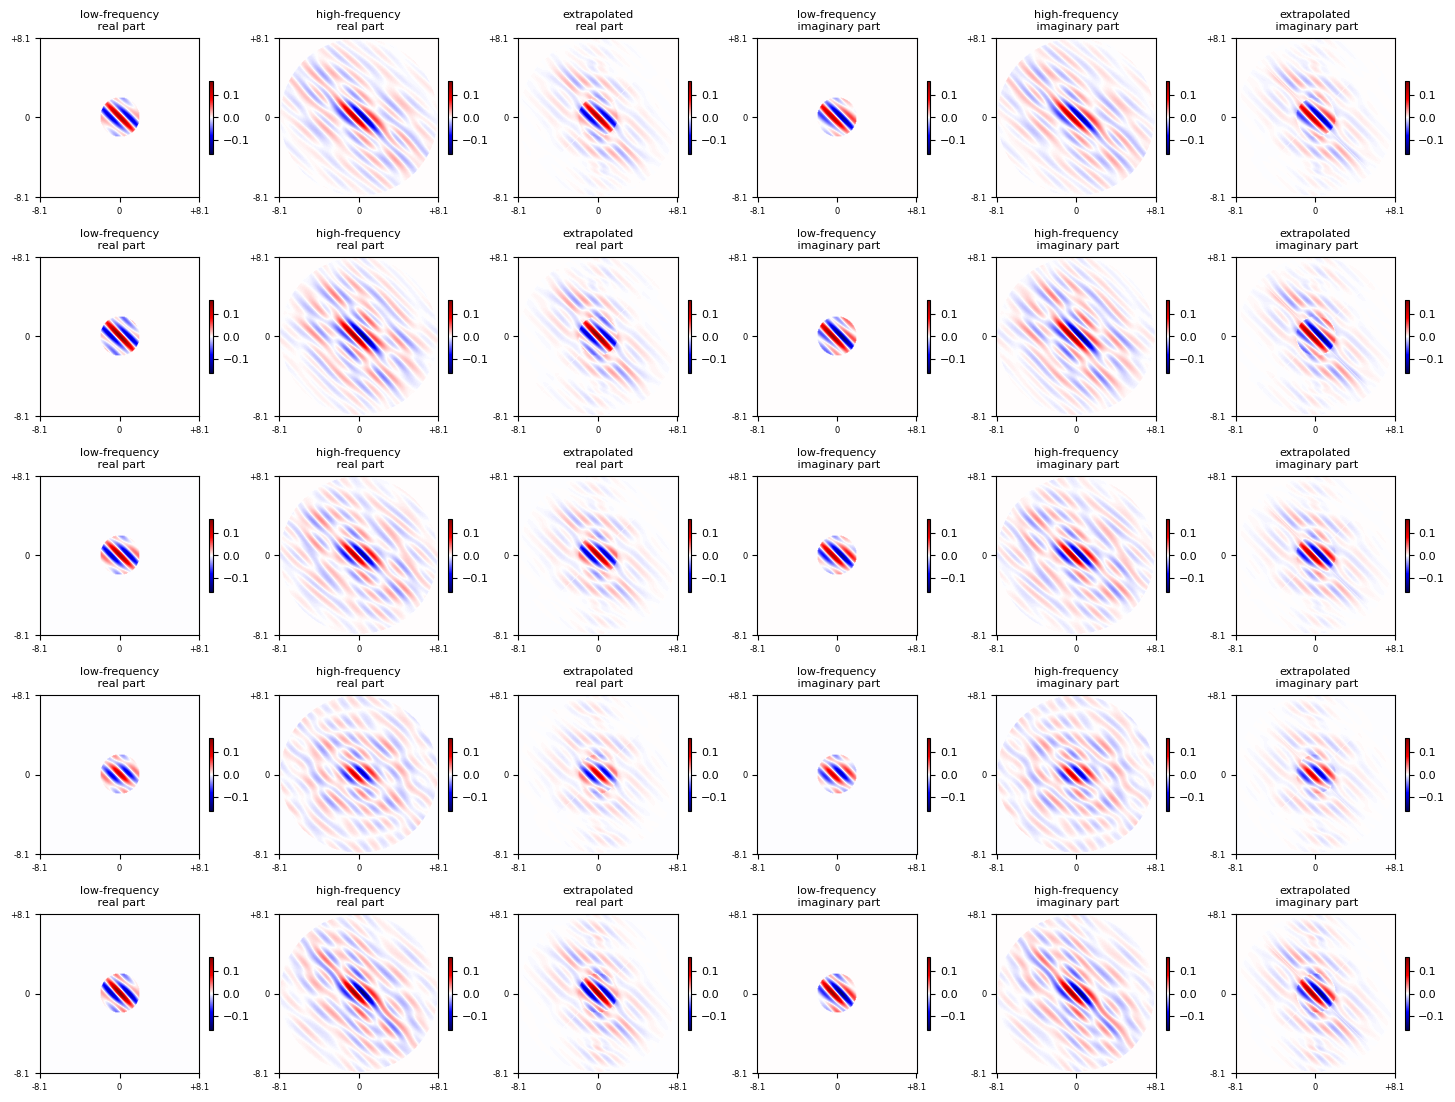

In [25]:
x_max = np.max([ np.abs(X_los).max(), np.abs(X_his).max(), np.abs(X_exts).max() ])

plt.figure(figsize=(18, 2.75 * num_imgs))
for I, (X_lo, X_hi, X_ext) in enumerate(zip(X_los, X_his, X_exts)):
  plt.subplot(num_imgs, 6, 1 + 6 * I)
  plt.imshow(X_lo.real, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
  plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.title(f'low-frequency\n real part', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 6, 2 + 6 * I)
  plt.imshow(X_hi.imag, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
  plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.title(f'high-frequency\n real part', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 6, 3 + 6 * I)
  plt.imshow(X_ext.real, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
  plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.title(f'extrapolated\n real part', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)

  plt.subplot(num_imgs, 6, 4 + 6 * I)
  plt.imshow(X_lo.imag, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
  plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.title(f'low-frequency\n imaginary part', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 6, 5 + 6 * I)
  plt.imshow(X_hi.imag, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
  plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.title(f'high-frequency\n imaginary part', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 6, 6 + 6 * I)
  plt.imshow(X_ext.imag, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
  plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=6)
  plt.title(f'extrapolated\n imaginary part', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(12, 7))
plt.subplot(2, 3, 1)
plt.imshow(X_los[0].real, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.title(f'low-frequency\n real part', fontsize=14)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.subplot(2, 3, 2)
plt.imshow(X_his[0].imag, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.title(f'high-frequency\n real part', fontsize=14)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.subplot(2, 3, 3)
plt.imshow(X_exts[0].real, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.title(f'extrapolated\n real part', fontsize=14)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.subplot(2, 3, 4)
plt.imshow(X_los[0].imag, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.title(f'low-frequency\n imaginary part', fontsize=14)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.subplot(2, 3, 5)
plt.imshow(X_his[0].imag, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.title(f'high-frequency\n imaginary part', fontsize=14)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
plt.subplot(2, 3, 6)
plt.imshow(X_exts[0].imag, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
plt.xticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.yticks([ 0, (num_w - 1) / 2, num_w-1 ], labels=[ f'{-w_max:+.1f}', '0', f'{+w_max:+.1f}' ], fontsize=12)
plt.title(f'extrapolated\n imaginary part', fontsize=14)
cb = plt.colorbar(shrink=0.4)
cb.ax.tick_params(labelsize=10)
savefig('EXT_RI', data_digit)
plt.close()

Compute low-frequency and high-frequency approximations.

In [26]:
# low- and high-frequency
X_los = np.array([ inverse_fourier_transform_2d_squares(lambda w : DC_lo.eval_window(w) * f(w)[I], xo, DC_lo.width, M).reshape(N) for I in img_index ])
X_his = np.array([ inverse_fourier_transform_2d_squares(lambda w : DC_hi.eval_window(w) * f(w)[I], xo, DC_hi.width, M).reshape(N) for I in img_index ])

x_max = np.max([ np.abs(X_los).max(), np.abs(X_his).max() ])

print(f'Low-frequency')
print(f'Norm of imaginary part    {np.linalg.norm(X_los.imag)}')
print(f'Minimum of real part      {X_los.real.min()}')
print(f'High-frequency')
print(f'Norm of imaginary part    {np.linalg.norm(X_his.imag)}')
print(f'Minimum of real part      {X_his.real.min()}')

X_los = X_los.real
X_his = X_his.real

Low-frequency
Norm of imaginary part    2.8298828851000087e-14
Minimum of real part      -0.1393493696681366
High-frequency
Norm of imaginary part    1.482325443302774e-13
Minimum of real part      -0.24639608300630234


Compute superresolved images.

In [27]:
X_exts = np.zeros((num_imgs, N[0], N[1]), dtype=complex)
# frequency extrapolation
for I, index in enumerate(img_index):
  X_exts[I] = X_los[I]
  for mS, Sopt in zip(mSs, Sopts):
    fw = lambda w : (DC_hi.eval_window(w) * (1 - DC_lo.eval_window(w)) * mS.eval_windowed(Sopt, w/alpha) * f(w/alpha)[index])
    X_exts[I] = X_exts[I] + inverse_fourier_transform_2d_squares(fw, xo, DC_hi.width, M).reshape(N)

print(f'Extrapolated')
print(f'Norm of imaginary part    {np.linalg.norm(X_exts.imag)}')
print(f'Minimum of real part      {X_exts.real.min()}')

Extrapolated
Norm of imaginary part    0.014184077568021463
Minimum of real part      -0.14795435779311236


Plot results.

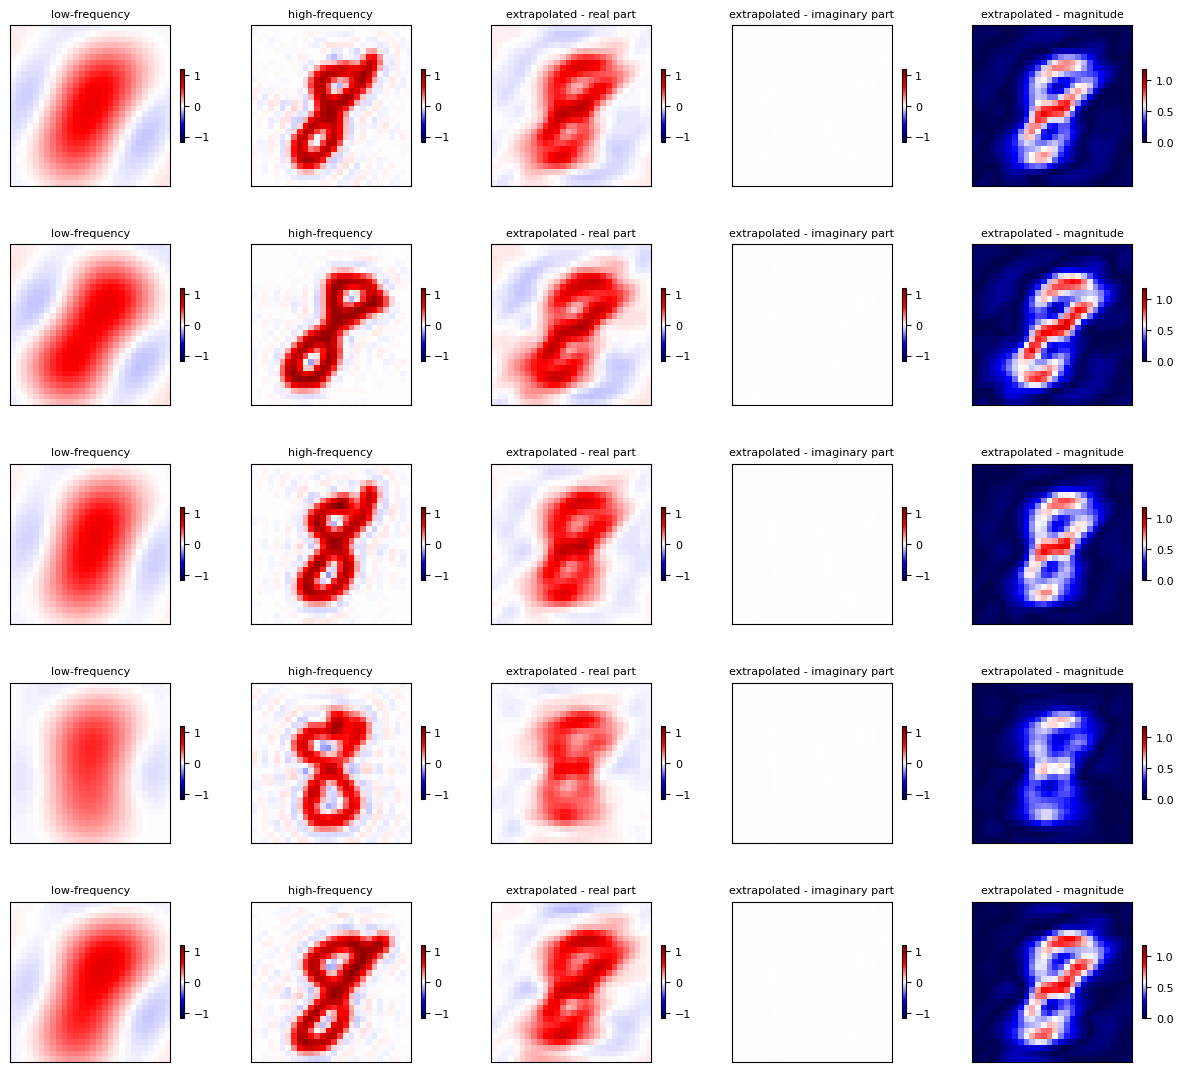

In [28]:
plt.figure(figsize=(15, 2.75 * num_imgs))
for I, (X_lo, X_hi, X_ext) in enumerate(zip(X_los, X_his, X_exts)):
  plt.subplot(num_imgs, 5, 1 + 5 * I)
  plt.imshow(X_lo, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
  plt.xticks([])
  plt.yticks([])
  plt.title(f'low-frequency', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 5, 2 + 5 * I)
  plt.imshow(X_hi, vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
  plt.xticks([])
  plt.yticks([])
  plt.title(f'high-frequency', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 5, 3 + 5 * I)
  plt.imshow(X_ext.real, vmin=-x_max, vmax=x_max, origin='lower', cmap='seismic')
  plt.xticks([])
  plt.yticks([])
  plt.title(f'extrapolated - real part', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 5, 4 + 5 * I)
  plt.imshow(X_ext.imag, vmin=-x_max, vmax=x_max, origin='lower', cmap='seismic')
  plt.xticks([])
  plt.yticks([])
  plt.title(f'extrapolated - imaginary part', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
  plt.subplot(num_imgs, 5, 5 + 5 * I)
  plt.imshow(np.abs(X_ext), vmin=0.0, vmax=x_max, origin='lower', cmap='seismic')
  plt.xticks([])
  plt.yticks([])
  plt.title(f'extrapolated - magnitude', fontsize=8)
  cb = plt.colorbar(shrink=0.4)
  cb.ax.tick_params(labelsize=8)
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(12, 7))
plt.subplot(1, 3, 1)
plt.imshow(X_los[0], vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
plt.xticks([])
plt.yticks([])
plt.title(f'low-frequency', fontsize=14)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
plt.subplot(1, 3, 2)
plt.imshow(X_his[0], vmin=-x_max, vmax=+x_max, origin='lower', cmap='seismic')
plt.xticks([])
plt.yticks([])
plt.title(f'high-frequency', fontsize=14)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
plt.subplot(1, 3, 3)
plt.imshow(X_exts[0].real, vmin=-x_max, vmax=x_max, origin='lower', cmap='seismic')
plt.xticks([])
plt.yticks([])
plt.title(f'extrapolated', fontsize=14)
cb = plt.colorbar(shrink=0.2)
cb.ax.tick_params(labelsize=10)
savefig('EXT_X', data_digit)
plt.close()